# Bitcoin Time-Series Study
## Sequence Forecasting with a Bidirectional LSTM (TensorFlow/Keras)

#### Prepared by: Pawan Chaudhary

This notebook documents a Bitcoin price forecasting pipeline. I convert historical daily prices into sliding windows, train a Bidirectional LSTM to predict the next day’s Close price, and evaluate predictions by inverting the scaling and visually comparing predicted vs actual prices.

The goal here is not to claim trading profitability. The goal is to build a correct, reproducible baseline forecasting system that demonstrates how to structure time-series data for deep learning and how to validate model behavior using diagnostics, plots, and limitations.

## Problem Motivation

Bitcoin is a classic example of a non-stationary time series: the scale changes over time, volatility comes in regimes, and simple patterns often break across market conditions. Even with those difficulties, forecasting next-step price levels is a practical learning problem because it forces me to solve the real engineering issues that matter in time-series deep learning:

- time-aware splitting 
- scaling without contaminating the test set
- converting a 1D series into supervised learning samples using sliding windows
- interpreting model performance beyond just a loss number

## System Constraint and Design Philosophy

I am building this notebook under CPU-first constraints. That changes how I design the pipeline:
- I keep the model architecture modest so training finishes in reasonable time.
- I avoid GPU-only layers (I do not use CuDNN-specific LSTMs).
- I keep the sequence length and batch size at values that do not stall my machine.
- I focus on correctness and reproducibility before increasing complexity.

When CPU is the bottleneck, my goal is not to maximize model size. My goal is to create a stable pipeline that I can iterate on, commit in stages, and defend as a research artifact.

In [2]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/332.0 MB 6.8 MB/s eta 0:00:49
   ---------------------------------------- 3.9/332.0 MB 12.9 MB/s eta 0:00:26
    --------------------------------------- 7.9/332.0 MB 15.1 MB/s eta 0:00:22
   - -------------------------------------- 12.1/332.0 MB 17.0 MB/s eta 0:00:19
   - -------------------------------------- 15.7/332.0 MB 17.2 MB/s eta 0:00:19
   -- ------------------------------------- 19.9/332.0 MB 17.7 MB/s eta 0:00:18
   -- ------------------------------------- 23.3/332.0 MB 17.4 MB/s eta 0:00:18
   --- ------------------------------------ 28.3/332.0 MB 18.1 MB/s eta 0:00:17
   --- ------------------------------------ 33.0/332.0 MB 18.5 MB/s eta 0:00:17
   ---- ----------------------------------- 37.7/332.0 MB 18.9 MB/s eta 0:00:16
   ----- ---------------------------------- 42.2/332.0 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
# Importing core libraries and plotting defaults

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Dense, LSTM, Activation

In [6]:
# Reproducibility to assure training results are less random between runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Plot defaults to keep figures readable for time-series inspection
plt.rcParams["figure.figsize"] = (12, 6)

## Loading the Bitcoin dataset

This project uses a local CSV dataset that I committed into found in Kaggle. My first responsibility is to load it into a DataFrame and confirm:
- the Date column is parsed correctly
- the dataset is sorted chronologically
- numeric columns are actually numeric (not comma-formatted strings)

In [9]:
DATA_PATH = "bitcoin_history.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Feb 20, 2025","96,628.40","98,722.29","96,481.41","98,347.95","98,347.95","31,327,236,096"
1,"Feb 19, 2025","95,532.53","96,855.59","95,011.97","96,635.61","96,635.61","28,990,872,862"
2,"Feb 18, 2025","95,773.81","96,695.38","93,388.84","95,539.55","95,539.55","37,325,720,482"
3,"Feb 17, 2025","96,179.01","97,032.23","95,243.55","95,773.38","95,773.38","27,336,550,690"
4,"Feb 16, 2025","97,580.49","97,725.59","96,060.98","96,175.03","96,175.03","16,536,755,396"


In [11]:
df.shape

(3810, 7)

In [13]:
df.dtypes

Date         object
Open         object
High         object
Low          object
Close        object
Adj Close    object
Volume       object
dtype: object

In [16]:
# Date parsing and chronological ordering
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

In [17]:
# Removing commas and converting it to numeric.
numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(",", "", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [20]:
# Verifying existence of null values
df[["Date"] + numeric_cols].isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [22]:
# Confirming the usable date range after cleanup.
df["Date"].min(), df["Date"].max(), df.shape

(Timestamp('2014-09-17 00:00:00'), Timestamp('2025-02-20 00:00:00'), (3810, 7))

## Visual sanity check: Close price over time

Before scaling or modeling, I want to visually confirm the series looks like a real Bitcoin price curve and not a corrupted parse. This plot is a quick “does the data behave like a time series” check.

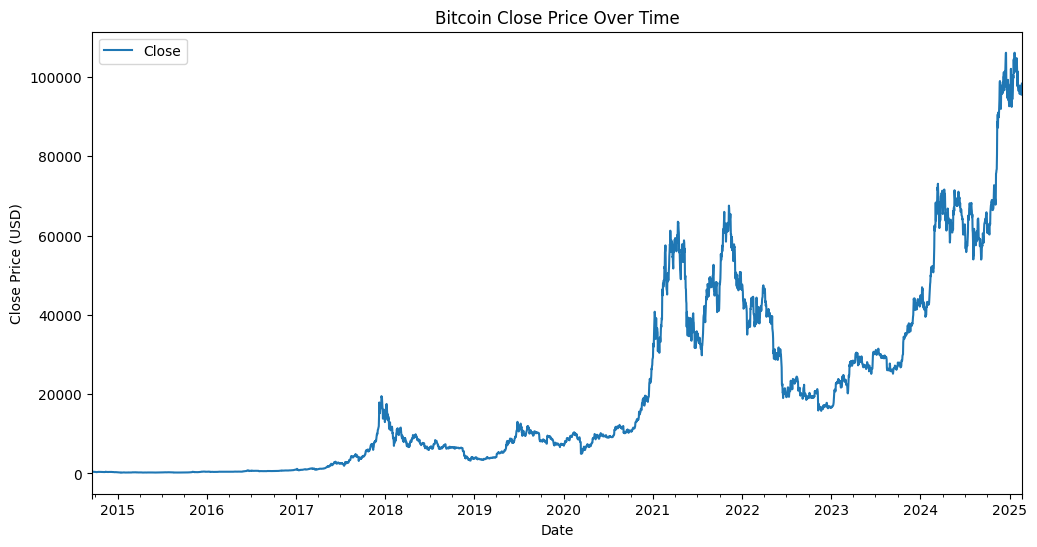

In [24]:
ax = df.plot(x="Date", y="Close")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
ax.set_title("Bitcoin Close Price Over Time")
plt.show()

### Figure Summary

This plot shows the Close price across the dataset timeline. The curve changes scale across time and exhibits distinct regimes where price levels and volatility shift. This confirms that the series is non-stationary and that any forecasting model must be evaluated with care, since “trend-following” behavior can look visually convincing even when the true predictive signal is weak.

## Normalization

LSTMs are sensitive to scale. Raw price values can vary by orders of magnitude across years, which makes optimization unstable. I use MinMax scaling so the model trains on a stable numeric range.

A practical detail matters here: scaling should be fit on training data only to avoid leakage. However, to keep this notebook structurally aligned with the reference pipeline, I first demonstrate the mechanics using the full series, then later I show the correct fit/transform split.

I treat this as a deliberate teaching step, not as the final research-standard choice.

In [26]:
scaler = MinMaxScaler()

close_price = df["Close"].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape


(3810, 1)

In [28]:
# NaNs often come from parsing problems or missing values.
np.isnan(scaled_close).any()

np.False_

## Preprocessing: turning a time series into supervised samples

A neural network does not understand time unless I explicitly package time into the input. I do that by constructing sliding windows:
- each sample is a fixed-length window of past values
- the label is the next value right after the window

This creates a sequence-to-one dataset:
X = [t-seq_len ... t-1] -> y = [t]

Getting shapes right here is the foundation for everything. If shapes are wrong, the model can train but learn meaningless mappings.

In [30]:
SEQ_LEN = 60 

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index : index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    # X: all but the last timestep in the window
    # y: the last timestep (next-day target)
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

## Train/test split: respecting time ordering

In time-series forecasting, random shuffling breaks the problem. If future data leaks into training, evaluation becomes inflated and misleading. I split chronologically: earlier samples are training, later samples are testing.

I start with a 90/10 split here to keep enough training history while still holding out a meaningful recent segment. I can adjust later if needed.

In [32]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split=0.90)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3375, 59, 1), (3375, 1), (375, 59, 1), (375, 1))

At this point, I expect the following:
- X_train is (n_samples, window_size, n_features)
- y_train is (n_samples, n_features)
- n_features should be 1 because I am predicting Close only
- window_size = SEQ_LEN - 1 because I use the last element of each window as the label

If these shapes do not match expectations, I stop and fix this before building the model.

## Model: Bidirectional LSTM for next-step forecasting

I use a Bidirectional LSTM model to learn patterns across the input window. I keep the architecture modest because:
- I want a stable baseline before scaling complexity
- I avoid CuDNN-specific LSTMs to keep this portable across machines.

In [34]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(
    Bidirectional(
        LSTM(64, return_sequences=True),
        input_shape=(WINDOW_SIZE, X_train.shape[-1])
    )
)
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(64, return_sequences=False)))

model.add(Dense(units=1))
model.add(Activation("linear"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 59, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 59, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 59, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

## Training Objective and Optimization

This is a regression problem: I predict a continuous value (scaled Close). I use mean squared error because it is the standard baseline loss for forecasting. I also keep shuffle=False because time-series order should not be randomized.

I treat loss curves as diagnostics. If training loss improves but validation loss does not, I assume the model is not generalizing or the data prep is flawed.

In [35]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam"
)

BATCH_SIZE = 32
EPOCHS = 20

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - loss: 0.0042 - val_loss: 0.0113
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.0051 - val_loss: 0.0114
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.0055 - val_loss: 0.0084
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12

## Training diagnostics: loss curves as early warnings

Loss curves are not cosmetic. They are my first validation that the pipeline is coherent.
- If both losses decrease, the model is learning a stable mapping.
- If validation loss is flat, I assume underfitting or bad features.
- If validation loss explodes or oscillates, I assume learning instability or too-large model/batch.

This connects directly to evaluation. If training is unstable, any forecast plot will be misleading.

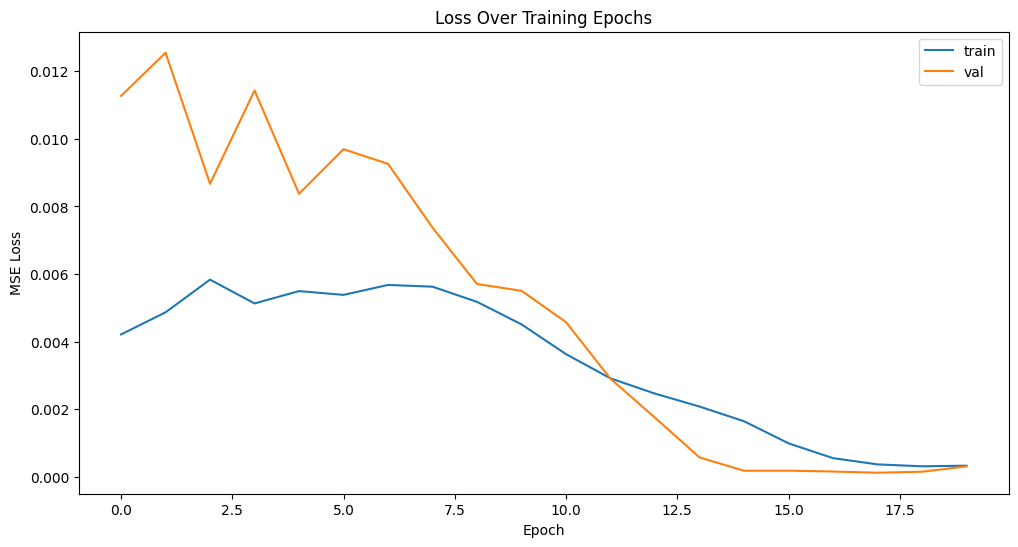

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Over Training Epochs")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

### Figure Summary

This plot shows training and validation loss across epochs. When both curves trend downward and remain reasonably close, it suggests the model is learning a generalizable mapping rather than memorizing a small subset of windows. If the curves diverge sharply, I treat that as a sign to reduce model capacity, increase regularization, or revisit preprocessing.

## Forecasting and inverse scaling

The model predicts values in scaled space, but interpretation must happen in the original price scale. I invert the scaling for both:
- y_test (actual)
- y_hat (predicted)

This makes the final plot meaningful, because I can inspect where predictions track the actual curve and where they lag or drift.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


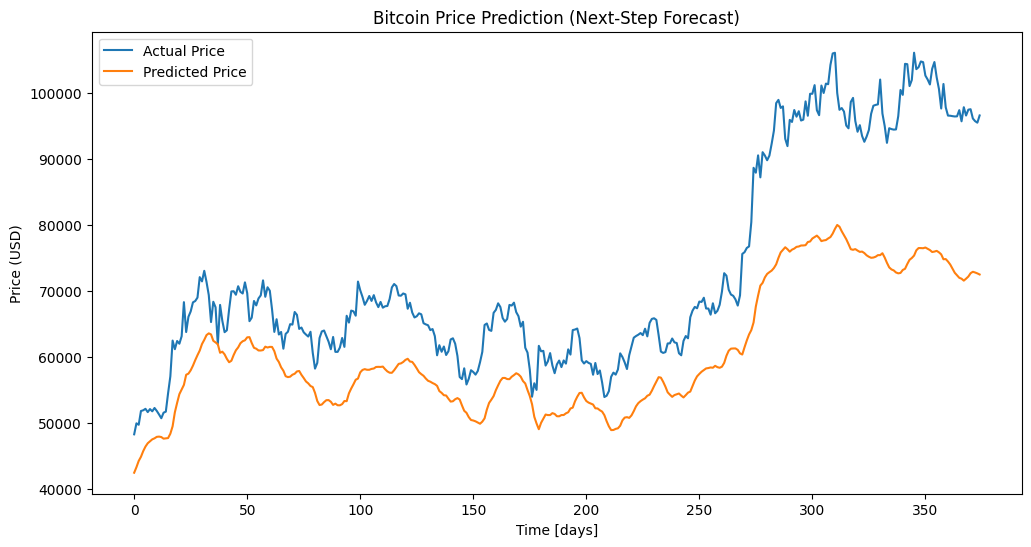

In [39]:
y_hat = model.predict(X_test)

# Inverse transform back to USD scale
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price")
plt.plot(y_hat_inverse, label="Predicted Price")
plt.title("Bitcoin Price Prediction (Next-Step Forecast)")
plt.xlabel("Time [days]")
plt.ylabel("Price (USD)")
plt.legend(loc="best")
plt.show()

### Figure Summary

This plot compares predicted vs actual Close prices over the held-out test segment. Forecasting quality is visible as how closely the predicted curve tracks the actual curve. In many price-level forecasting setups, the model can appear to perform well by learning smooth trend-following behavior, while still failing to anticipate sharp regime changes. Because of that, I interpret this plot as a qualitative diagnostic, not as proof of strong predictive power.

In [42]:
# I save the model so I can reproduce predictions without retraining every time.

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "bitcoin_lstm.keras")
model.save(MODEL_PATH)

MODEL_PATH

'models\\bitcoin_lstm.keras'

## Summary

In this notebook, I implemented a Bitcoin forecasting pipeline as a sequence-to-one regression problem. I loaded and cleaned a local historical dataset, converted Close prices into sliding windows, trained a Bidirectional LSTM to predict the next Close value, and evaluated the output by inverting the scaling and visually comparing predicted vs actual curves. I also used loss curves as diagnostics to validate that training behavior is coherent.

## Limitations

The biggest limitation of this setup is that predicting price levels can look better than it truly is because price series are autocorrelated and trend-dominated in many segments. A model can produce visually smooth predictions without capturing meaningful predictive structure, especially during regime shifts. Another limitation is evaluation methodology: a single fixed split is useful for a baseline, but it is not a complete robustness check. Finally, scaling should be fit using training data only to avoid leakage. Even if leakage impact seems small, it matters for research defensibility.

## What to Improve Next

My next practical improvements should increase rigor without exploding compute:
- Add a naive baseline (y[t] = y[t-1]) and compare MAE/RMSE.
- Fit scaler only on training segment, then transform test segment separately.
- Add walk-forward validation to test stability across multiple time periods.
- Extend input features beyond Close (OHLCV) and evaluate whether extra context improves forecasts.